In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pulp import LpProblem, LpMaximize, LpVariable, lpSum

from utils import TaskAllocation

### Load input data

In [2]:
# Copy the file into an in-memory buffer to avoid Permission error if the file is open in Excel
input_filename = "inputs.xlsx"

skills_df = pd.read_excel(input_filename, sheet_name="skills", engine="openpyxl")
skills_df.set_index("agent", inplace=True)
tasks_df = pd.read_excel(input_filename, sheet_name="tasks", engine="openpyxl")
tasks_df.set_index("language", inplace=True)

Validate the input data

In [3]:
agents = skills_df.index.to_list()
capacity = skills_df["capacity"]
languages = ["en", "de", "fr", "it"]
nonproduct_columns = ["capacity"] + languages
assert skills_df.columns[: len(nonproduct_columns)].tolist() == nonproduct_columns
# identify products in skills_df and check tasks_df matches
products = skills_df.columns[len(nonproduct_columns) :].tolist()
assert tasks_df.columns.tolist() == products
assert tasks_df.index.tolist() == languages
# check that skills only has y / None
assert (
    skills_df[languages + products].isin(["y", np.nan]).all().all()
), "skills table has unexpected values"
# convert to boolean
skills_df[languages + products] = skills_df[languages + products] == "y"

ta = TaskAllocation(agents, products, languages, capacity)

print(f"products: {products}")
print(f"total tasks: {tasks_df.sum().sum():.0f}")

products: ['hypo', 'card', 'pension', 'invest']
total tasks: 577


### Initialize the optimization problem

In [4]:
prob = LpProblem("task_allocation", LpMaximize)

### Variables

In [5]:
# x_{i,j,k} ... number of tasks assigned to agent i for product j in language k
x = {
    (agent, product, language): LpVariable(
        f"x_{agent}_{product}_{language}", lowBound=0, cat="Integer"
    )
    for agent in skills_df.index
    for product in products
    for language in languages
}

### Constraints

In [6]:
# total number of tasks assigned to agent i less than capacity
utilization = {
    agent: lpSum(x[agent, product, language] for product in products for language in languages)
    for agent in agents
}

for agent in agents:
    prob += utilization[agent] <= capacity[agent]

# if agent does not have skill for product or language, then no tasks assigned
for agent in agents:
    for product in products:
        for language in languages:
            if not (skills_df.loc[agent, product] and skills_df.loc[agent, language]):
                prob += x[agent, product, language] == 0

# number of assigned tasks per product and language does not exceed available tasks
for product in products:
    for language in languages:
        prob += (
            lpSum(x[agent, product, language] for agent in agents)
            <= tasks_df.loc[language, product]
        )

### Objective function

In [7]:
# total number of tasks assigned
total_tasks = lpSum(x.values())
prob.setObjective(total_tasks)


### Solution

Tasks assigned: 577


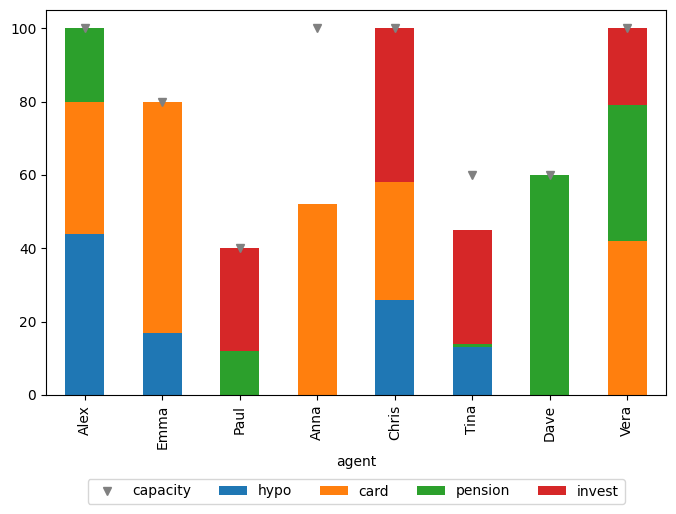

In [8]:
prob.solve()
print(f"Tasks assigned: {total_tasks.value():.0f}")
allocation_df = ta.get_allocation_df(prob, x, groupby="product")
ta.plot_allocation(allocation_df)
plt.show()

### Equalize workload by adding max underutilization penalty

In [9]:
# introduce an auxiliary variable to linearize the max operator
max_underutilization = LpVariable("max_underutilization", lowBound=0, cat="Continuous")

for agent in agents:
    prob += max_underutilization >= (capacity[agent] - utilization[agent])/capacity[agent]

prob.setObjective(total_tasks - max_underutilization)

Tasks assigned: 577
max underutilization: 16%


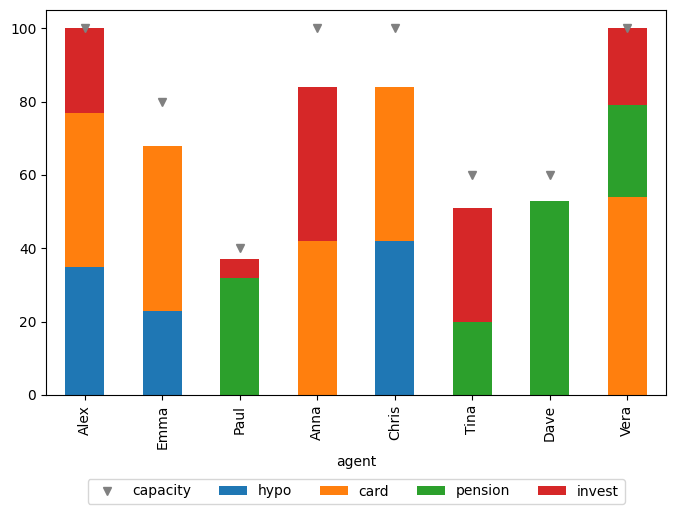

In [10]:
prob.solve()
print(f"Tasks assigned: {total_tasks.value():.0f}")
print(f"max underutilization: {100*max_underutilization.value():.0f}%")
allocation_df = ta.get_allocation_df(prob, x, groupby="product")
ta.plot_allocation(allocation_df)
plt.show()

### Improve distribution of products per agent

In [11]:
target_df = pd.DataFrame(0, index=agents, columns=products)
target_df.index.name = "agent"
target_df.columns.name = "product"

deviation = {
    (agent, product): LpVariable(f"{agent}_{product}", lowBound=0, cat="Continuous")
    for agent in agents
    for product in products
}

for agent in agents:
    # calculate the number of suitable tasks
    suitable_tasks = tasks_df.loc[skills_df.loc[agent, languages], skills_df.loc[agent, products]]
    # aggregate over languages
    suitable_tasks = suitable_tasks.sum(axis=0)
    target_tasks = capacity[agent] * suitable_tasks / suitable_tasks.sum()
    target_df.loc[agent, suitable_tasks.index.values] = np.floor(target_tasks)

    for product in products:
        n_target = target_df.loc[agent, product]
        n_assigned = lpSum(x[agent, product, language] for language in languages)
        # above target
        prob += deviation[agent, product] >= n_assigned - (n_target + 1)
        # below target
        prob += deviation[agent, product] >= n_target - n_assigned

# penalize objective for deviation from target
total_deviation = lpSum(deviation)
deviation_weight = 0.1
prob.setObjective(total_tasks - max_underutilization - deviation_weight * total_deviation)

Tasks assigned: 577


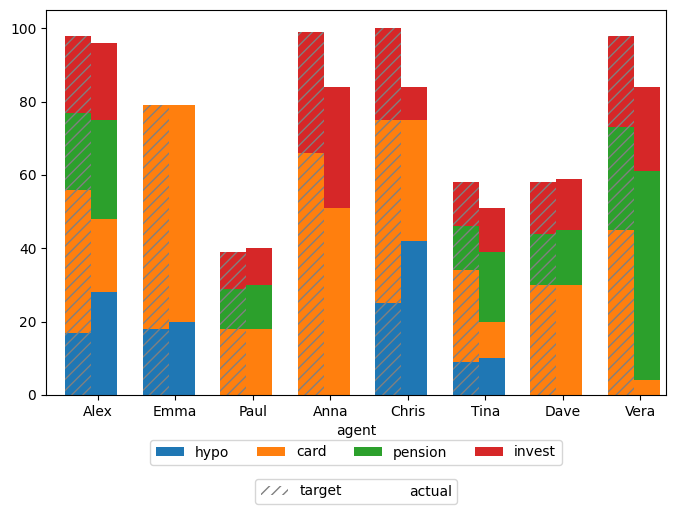

In [12]:
prob.solve()
print(f"Tasks assigned: {total_tasks.value():.0f}")
allocation_df = ta.get_allocation_df(prob, x, groupby="product")
ta.plot_allocation_vs_target(target_df, allocation_df, ["target", "actual"], title=None, figsize=(8, 5))
plt.show()